<a href="https://colab.research.google.com/github/relhwigi/GE_GRAPE_Mammogram_Classification/blob/main/Mammography_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learning using Grammatical Evolution**
###Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Mounting drive***

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### ***Clone grammar repository***

In [2]:
import os.path

PATH = '/content/drive/MyDrive/GE_GRAPE_Mammogram_Classification/'
if os.path.exists(PATH):
    print('grammar directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/relhwigi/GE_GRAPE_Mammogram_Classification.git
    print('Cloning repo in your Drive')

grammar directory already exists


### ***Clone GRAPE repository***

In [3]:
PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

grape directory already exists
/content/drive/MyDrive/grape


In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [5]:
!pip install deap==1.3 

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 152 kB 8.6 MB/s 


### ***Data Exploration***

There are 2 datasets availble. A larger data set containing the full data and a smaller data set containing a subset of the data.

**Large dataset**

In [6]:
# loading in the full dataset into a pandas dataframe from GitHub
full_data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02.csv')

# checking the data
full_data.head()

,PatientID,StudyID,PatientAge,ImgID,View,SegmentPosition,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,...,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,Label
0,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,LA1,0.019791,70.750121,0.986798,2679.422225,0.280588,147.661857,10646.938779,7.747646,11.202839,0.000314,4.076002,-0.375260,0.997168,0.019626,84.163154,0.984285,2677.867573,0.265944,147.683884,10627.307136,7.747549,11.323964,0.000289,4.197319,-0.358078,0.996413,0.019630,77.824490,0.985561,2694.966117,0.275523,147.909924,10702.039977,7.754164,...,0.009253,87.836024,0.972762,1612.354750,0.234180,125.710824,6361.582974,7.734123,11.454076,0.000271,4.262486,-0.325168,0.994130,0.009331,78.661818,0.975880,1630.642198,0.251513,125.959761,6443.906973,7.742087,11.349892,0.000295,4.170668,-0.341879,0.995351,0.009309,91.440624,0.971643,1612.335914,0.236469,125.710631,6357.903033,7.732227,11.447468,0.000271,4.279557,-0.326134,0.994207,0
1,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,RA1,0.994207,-0.326134,4.279557,0.000271,11.447468,7.732227,6357.903033,125.710631,0.236469,1612.335914,0.971643,91.440624,0.009309,0.995351,-0.341879,4.170668,0.000295,11.349892,7.742087,6443.906973,125.959761,0.251513,1630.642198,0.975880,78.661818,0.009331,0.994130,-0.325168,4.262486,0.000271,11.454076,7.734123,6361.582974,125.710824,...,0.996896,-0.368340,4.131941,0.000304,11.259636,7.754164,10702.039977,147.909924,0.275523,2694.966117,0.985561,77.824490,0.019630,0.996413,-0.358078,4.197319,0.000289,11.323964,7.747549,10627.307136,147.683884,0.265944,2677.867573,0.984285,84.163154,0.019626,0.997168,-0.375260,4.076002,0.000314,11.202839,7.747646,10646.938779,147.661857,0.280588,2679.422225,0.986798,70.750121,0.019791,0
2,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,LB1,0.176898,29.279795,0.991535,1729.360146,0.543738,69.492803,6888.160789,5.588478,7.678311,0.001063,3.007836,-0.466993,0.995340,0.176755,38.247695,0.988937,1728.676323,0.527879,69.472768,6876.457598,5.587467,7.788665,0.001018,3.140099,-0.444989,0.994189,0.176731,36.386574,0.989479,1729.238136,0.536824,69.479784,6880.565969,5.589269,...,0.092548,49.175862,0.974096,949.183578,0.426549,70.014061,3747.558450,6.123452,8.832584,0.000764,3.565872,-0.374187,0.991387,0.092727,41.654020,0.978061,949.293642,0.442741,70.019677,3755.520550,6.123813,8.724835,0.000808,3.457819,-0.394026,0.993063,0.092775,43.496564,0.977087,949.179329,0.434262,70.013911,3753.220753,6.121706,8.761205,0.000787,3.495691,-0.387325,0.992537,0
3,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,RB1,0.992537,-0.387325,3.495691,0.000787,8.761205,6.121706,3753.220753,70.013911,0.434262,949.179329,0.977087,43.496564,0.092775,0.993063,-0.394026,3.457819,0.000808,8.724835,6.123813,3755.520550,70.019677,0.442741,949.293642,0.978061,41.654020,0.092727,0.991387,-0.374187,3.565872,0.000764,8.832584,6.123452,3747.558450,70.014061,...,0.994659,-0.453387,3.096423,0.001041,7.746667,5.589269,6880.565969,69.479784,0.536824,1729.238136,0.989479,36.386574,0.176731,0.994189,-0.444989,3.140099,0.001018,7.788665,5.587467,6876.457598,69.472768,0.527879,1728.676323,0.988937,38.247695,0.176755,0.995340,-0.466993,3.007836,0.001063,7.678311,5.588478,6888.160789,69.492803,0.543738,1729.360146,0.991535,29.279795,0.176898,0
4,optm1,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,65,1.2.826.0.1.3680043.9.3218.1.1.15315205.3583.1...,CC,LC1,0.525843,7.001352,0.994143,597.735239,0.796829,25.326144,2383.939606,2.888570,3.765628,0.003221,1.616226,-0.557700,0.972441,0.526075,8.623873,0.992788,597.848247,0.789314,25.3

**Smaller dataset**

In [7]:
# loading in the sample dataset into a pandas dataframe from GitHub
some_data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

# checking the data
some_data.tail()

,PatientID,StudyID,PatientAge,ImgID,View,SegmentPosition,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,...,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,Label
24994,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,LC4,0.580839,3.045049,0.997699,661.727190,0.836922,26.268896,2643.863713,2.494799,3.163219,0.003258,1.314591,-0.599526,0.966099,0.580497,7.801042,0.994106,661.792593,0.815975,26.252181,2639.369329,2.496087,3.296281,0.003155,1.509786,-0.539391,0.955178,0.580715,5.653316,0.995729,661.779929,0.824111,26.248573,2641.466402,2.496146,...,0.740933,4.768997,0.996091,609.972040,0.893421,17.894553,2435.119162,1.634581,2.096980,0.004058,0.990489,-0.595274,0.911536,0.740852,5.103426,0.995816,609.850151,0.896355,17.890689,2434.297178,1.635636,2.084555,0.004073,0.977859,-0.603467,0.913760,0.740632,7.332761,0.993989,609.970714,0.890533,17.894517,2432.550097,1.636074,2.120537,0.004044,1.030084,-0.579495,0.907051,0
24995,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,RC4,0.907051,-0.579495,1.030084,0.004044,2.120537,1.636074,2432.550097,17.894517,0.890533,609.970714,0.993989,7.332761,0.740632,0.913760,-0.603467,0.977859,0.004073,2.084555,1.635636,2434.297178,17.890689,0.896355,609.850151,0.995816,5.103426,0.740852,0.911536,-0.595274,0.990489,0.004058,2.096980,1.634581,2435.119162,17.894553,...,0.959646,-0.562159,1.439089,0.003190,3.244839,2.496146,2641.466402,26.248573,0.824111,661.779929,0.995729,5.653316,0.580715,0.955178,-0.539391,1.509786,0.003155,3.296281,2.496087,2639.369329,26.252181,0.815975,661.792593,0.994106,7.801042,0.580497,0.966099,-0.599526,1.314591,0.003258,3.163219,2.494799,2643.863713,26.268896,0.836922,661.727190,0.997699,3.045049,0.580839,0
24996,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,LD4,0.826577,0.954606,0.998275,276.728460,0.940576,9.732558,1105.959234,1.102387,1.339445,0.007334,0.598755,-0.672619,0.861793,0.826406,3.155421,0.994277,275.694855,0.929461,9.693805,1099.623999,1.102562,1.406288,0.007233,0.706477,-0.601921,0.837899,0.826833,1.641757,0.997022,275.683547,0.935430,9.694291,1101.092433,1.100626,...,0.954617,0.496889,0.997059,84.471798,0.983721,2.450195,337.390304,0.332656,0.396962,0.005391,0.206537,-0.708741,0.594332,0.954392,0.957006,0.994345,84.616243,0.982837,2.456086,337.507966,0.334070,0.402915,0.005385,0.219292,-0.691725,0.589005,0.954291,1.905002,0.988724,84.475163,0.981381,2.450326,335.995648,0.334633,0.412324,0.005377,0.236487,-0.658832,0.577138,0
24997,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,RD4,0.577138,-0.658832,0.236487,0.005377,0.412324,0.334633,335.995648,2.450326,0.981381,84.475163,0.988724,1.905002,0.954291,0.589005,-0.691725,0.219292,0.005385,0.402915,0.334070,337.507966,2.456086,0.982837,84.616243,0.994345,0.957006,0.954392,0.594332,-0.708741,0.206537,0.005391,0.396962,0.332656,337.390304,2.450195,...,0.851051,-0.640413,0.648221,0.007284,1.367621,1.100626,1101.092433,9.694291,0.935430,275.683547,0.997022,1.641757,0.826833,0.837899,-0.601921,0.706477,0.007233,1.406288,1.102562,1099.623999,9.693805,0.929461,275.694855,0.994277,3.155421,0.826406,0.861793,-0.672619,0.598755,0.007334,1.339445,1.102387,1105.959234,9.732558,0.940576,276.728460,0.998275,0.954606,0.826577,0
24998,optm1344,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,66,1.2.826.0.1.3680043.9.3218.1.1.1404259.6176.15...,MLO,LE4,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.00

**Extracting information on the data**

*Size of full dataset*

In [8]:
# number of rows in full dataset
full_number_of_samples = full_data['PatientID'].count()
full_number_of_samples

405280

*Size of sample dataset*

In [9]:
# number of rows in some dataset
some_number_of_samples = some_data['PatientID'].count()
some_number_of_samples

24999

*Visualisation of size difference*

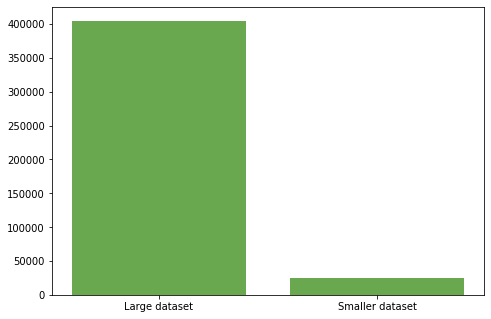

In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sets = ['Large dataset', 'Smaller dataset']
samples = [full_number_of_samples, some_number_of_samples]
ax.bar(sets,samples, color="#6aa84f")
plt.show()

*Full dataset label distribution*

In [11]:
# number of positive and negative cases in full dataset
full_label_distribution = full_data['Label'].value_counts()
full_label_distribution

0    393021
1     12259
Name: Label, dtype: int64


*Visualisation of label distribution*

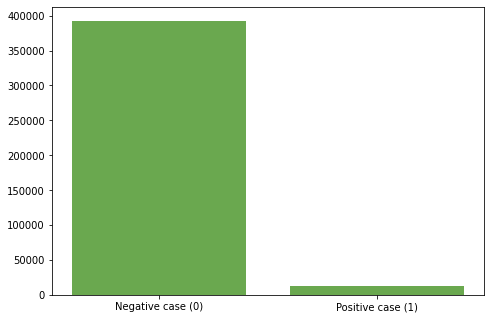

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
label = ['Negative case (0)', 'Positive case (1)']
ax.bar(label , full_label_distribution, color="#6aa84f")
plt.show()

*Some dataset label distribution*

In [13]:
# number of positive and negative cases in some dataset
some_label_distribution = some_data['Label'].value_counts()
some_label_distribution

0    24018
1      981
Name: Label, dtype: int64

*Mammogram views*

In [14]:
# the different mammogram views in the dataset
views = full_data.View.unique()
views

array(['CC', 'MLO', 'XCCL', 'ML', 'LM'], dtype=object)

In [15]:
# getting the number of times each row occurs
CC_popularity = len(full_data.loc[full_data['View'] == 'CC'])
MLO_popularity = len(full_data.loc[full_data['View'] == 'MLO'])
XCCL_popularity = len(full_data.loc[full_data['View'] == 'XCCL'])
ML_popularity = len(full_data.loc[full_data['View'] == 'ML'])
LM_popularity = len(full_data.loc[full_data['View'] == 'LM'])

In [16]:
CC_popularity

205520

In [17]:
MLO_popularity

199320

In [18]:
XCCL_popularity

120

In [19]:
ML_popularity

240

In [20]:
LM_popularity

80

*Percentage of samples that are CC or MLO view*

In [21]:
((CC_popularity+MLO_popularity)/full_number_of_samples)*100

99.89143308330043

*Mammogram segments*

In [22]:
# the different mammogram segments in the dataset
segments = full_data.SegmentPosition.unique()
segments

array(['LA1', 'RA1', 'LB1', 'RB1', 'LC1', 'RC1', 'LD1', 'RD1', 'LE1',
       'RE1', 'LA2', 'RA2', 'LB2', 'RB2', 'LC2', 'RC2', 'LD2', 'RD2',
       'LE2', 'RE2', 'LA3', 'RA3', 'LB3', 'RB3', 'LC3', 'RC3', 'LD3',
       'RD3', 'LE3', 'RE3', 'LA4', 'RA4', 'LB4', 'RB4', 'LC4', 'RC4',
       'LD4', 'RD4', 'LE4', 'RE4'], dtype=object)

*Approximate number of patients in full dataset*

In [23]:
len(full_data.PatientID.unique())

4919

Approximate number of patients in sample dataset

In [24]:
len(some_data.PatientID.unique())

315

*Columns in the datasets*

In [25]:
number_of_all_columns = len(full_data.columns)
number_of_all_columns

111

In [26]:
# the column names in both datasets are the same, extracting them here
all_columns = full_data.columns.to_list()

### ***Data Preprocessing***

The data is already very clean and concise but there are a few columns that are unnecessary for the task at hand. 

**Dropping columns from large dataset**

In [27]:
full_data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)
final_columns = full_data.columns.to_list()

**Dropping columns from smaller dataset**

In [28]:
some_data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [29]:
final_number_of_columns = len(final_columns)
final_number_of_columns

105

**Train and test split**

In [30]:
X = np.zeros([some_number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([some_number_of_samples,], dtype=int)

for i in range(some_number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = some_data['x'+ str(j)].iloc[i]
for i in range(some_number_of_samples):
    Y[i] = some_data['Label'].iloc[i]
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [31]:
 print('Training (X,Y):\t', X_train.shape, Y_train.shape)
 print('Test (X,Y):\t', X_test.shape, Y_test.shape)

Training (X,Y):	 (17499, 104) (17499,)
Test (X,Y):	 (7500, 104) (7500,)


In [32]:
print(Counter(Y_train))

Counter({0: 16809, 1: 690})


In [33]:
print(Counter(Y_test))

Counter({0: 7209, 1: 291})


**Oversample train data**

In [34]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(X_train, Y_train)
# new class distribution 
print(Counter(y_ros))

Counter({0: 16809, 1: 16809})


**Get transpose of X arrays**

In [35]:
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

### ***BNF Grammar***

**Check grammar file**

In [36]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

**Setup grammar**

In [37]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Fitness Function***

In [39]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  # Evaluate the expression
  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    # FP err can happen through eg overflow (lots of pow/exp calls)
    # ZeroDiv can happen when using unprotected operators
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  compare= np.equal(Y,Y_class)
  fitness= 1- np.mean(compare)

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [43]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 200
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 255

**Creating DEAP toolbox**

In [44]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=7)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [45]:
# create initial population (generation 0):
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

ValueError: ignored

**Statistics**

In [ ]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

**Best individual**

In [ ]:
print("Best individual: ")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

**Best individuals plots**

In [42]:
plt.plot(gen, min_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.show()

NameError: ignored

**Average fitness plot**

In [ ]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

In [ ]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()